# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos Agonistas de la Hormona GLP-1**

### Avance 3: Base Line Modelo Predictivo

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dra. Eduviges Ludivina Facundo Flores  – Profesor Tutor

### **Asesores**
- Dr. Juan Arturo Nolazco Flores
- Dr. Carlos Alberto Brizuela Rodríguez

#### **Miembros del equipo:**
- Cesar Ivan Herrera Martinez A01796392  
- Juan Antonio Cruz Acosta A01795375 
- Julio Baltazar Colín A01794476 

# Modelo Predictivo

## Introducción: 


#### Carga de los datos procesados

In [13]:
# Carga de archivos y librerias basicas

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Optional
import sys
import os
import pycaret
from pycaret.regression import *
from pycaret.utils import *

# Rutas locales a Bibliotecas y utilerias
from pathlib import Path

# ruta del directorio del notebook actual
notebook_dir = Path.cwd()

# Subir un nivel para llegar a la carpeta raíz del proyecto
project_root = notebook_dir.parent

# Añadir la carpeta raíz al path de Python
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"Ruta del proyecto añadida al path: {project_root}")


In [14]:
# Establecer la ruta los archivos de datos
directorio_base = Path("../")
directorio_datos = Path(directorio_base / "data")
directorio_modelos = Path(directorio_base / "models")
directorio_modelos_automl= Path(directorio_modelos / "pycaret")
raw_data_dir = directorio_datos / "raw"
processed_data_dir = directorio_datos / "processed"

# Rutas de archivos procesados

# Ruta archivo CSV con péptidos con actividad EC50
ruta_125_ec50= processed_data_dir/ "descriptores_125.csv"

# Ruta archivo con péptidos sinctividad EC50
ruta_peptidos_eval= processed_data_dir / "descriptores_cdhit.csv"


# Ruta archivo con péptidos con actividad EC50 filtrado con 20 descriptores de entropia
ruta_125_ent= processed_data_dir / "descriptores_Spearman.csv"

#  Ruta Modelos entrenados sin PCA
ruta_dir_modelos_no_pca = directorio_modelos_automl / "modelos_GLP1_no_pca"
#  Ruta top Modelos entrenados sin PCA 
ruta_modelo_stack_no_pca  = ruta_dir_modelos_no_pca / "modelo_GLP1_stack_no_pca"
#  Ruta Modelo Stack Final 
ruta_top_modelos_sin_pca = ruta_dir_modelos_no_pca / "top_modelos_GLP1_no_pca"
# ruta_dir_modelos_no_pca
ruta_pipeline_sin_pca = ruta_dir_modelos_no_pca / "pipeline_modelo_GLP1"


#  Ruta Modelos entrenados con PCA
ruta_dir_modelos_pca = directorio_modelos_automl / "modelos_GLP1_pca"
#  Ruta top Modelos entrenados con PCA
ruta_modelo_stack_pca  = ruta_dir_modelos_pca / "modelo_GLP1_stack_pca"
#  Ruta Modelo Stack Final
ruta_top_modelos_con_pca = ruta_dir_modelos_pca / "top_modelos_GLP1_pca"
# ruta_dir_modelos_pca
ruta_pipeline_con_pca = ruta_dir_modelos_pca / "pipeline_modelo_GLP1"

# ruta para guardar resultados
ruta_resultados_prediccion = directorio_datos / "Predicciones_Peptidos_GLP1.xlsx"

In [15]:
os.makedirs(ruta_dir_modelos_no_pca, exist_ok=True)
os.makedirs(ruta_dir_modelos_pca, exist_ok=True)

In [16]:
# Carga de Datos
df_conocidos = pd.read_csv(ruta_125_ec50)
df_conocidos.set_index('ID', inplace=True)
df_Entropia = pd.read_csv(ruta_125_ent)
df_Entropia.set_index('ID', inplace=True)
df_desconocidos = pd.read_csv(ruta_peptidos_eval)
df_desconocidos.set_index('ID', inplace=True)

# Transformación de EC50_T2 a pEC50 positivo como columna objetivo
df_conocidos['pEC50'] = -np.log10(df_conocidos["EC50_T2"] * 1e-12)
df_Entropia['EC50_LOG_T2'] = np.log10(df_Entropia["EC50_T2"] * 1e-12).round(2)
df_Entropia['pEC50'] = -np.log10(df_Entropia["EC50_T2"] * 1e-12)


In [17]:
df_Entropia.tail(3)


,EC50_T2,EC50_LOG_T2,CTDC_polarity.G2,CTDD_polarity.3.residue50,CTDD_hydrophobicity_PONP930101.1.residue75,CTDD_hydrophobicity_ENGD860101.1.residue50,CTDD_polarity.3.residue75,CTDD_polarity.2.residue75,CTDT_solventaccess.Tr1221,CTDD_hydrophobicity_ARGP820101.1.residue75,...,Moran_ANDN920101.lag3,Moran_ARGP820102.lag2,Moran_BEGF750101.lag1,Moran_BEGF750103.lag1,QSOrder_Grantham.Xd.1,Moran_BHAR880101.lag2,Moran_ARGP820103.lag2,QSOrder_Grantham.Xd.3,QSOrder_Grantham.Xd.2,pEC50
ID,,,,,,,,,,,,,,,,,,,,,
seq_pep123,29500.0,-7.53,0.400000,50.000000,60.000000,50.000000,66.666667,60.000000,0.241379,60.000000,...,0.043587,-0.120763,0.287381,-0.096412,0.333322,-0.113437,-0.048634,0.312807,0.353846,7.530178
seq_pep124,598.0,-9.22,0.333333,50.000000,56.666667,43.333333,70.000000,40.000000,0.344828,50.000000,...,0.199475,-0.187230,0.263141,-0.055953,0.389474,-0.012070,-0.104472,0.236960,0.373542,9.223299
seq_pep125,30200.0,-7.52,0.275862,44.827586,58.620690,44.827586,58.620690,37.931034,0.321429,62.068966,...,0.204238,0.051486,-0.027692,0.023646,0.370032,0.005384,0.037435,0.308356,0.321589,7.519993


In [18]:
# Exploración de los datos
df_conocidos.tail(3)

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,Moran_BHAR880101.lag2,Moran_BHAR880101.lag3,GAAC_alphatic,GAAC_aromatic,GAAC_postivecharge,GAAC_negativecharge,GAAC_uncharge,EC50_T2,EC50_LOG_T2,pEC50
ID,,,,,,,,,,,,,,,,,,,,,
seq_pep123,0.033333,0.0,0.066667,0.100000,0.066667,0.100000,0.033333,0.033333,0.033333,0.066667,...,-0.113437,-0.117154,0.300000,0.133333,0.100000,0.166667,0.300000,29500.0,-7.53,7.530178
seq_pep124,0.033333,0.0,0.066667,0.066667,0.100000,0.100000,0.033333,0.000000,0.033333,0.133333,...,-0.012070,0.012804,0.366667,0.166667,0.100000,0.133333,0.233333,598.0,-9.22,9.223299
seq_pep125,0.000000,0.0,0.103448,0.103448,0.103448,0.103448,0.034483,0.000000,0.034483,0.172414,...,0.005384,-0.108561,0.344828,0.137931,0.068966,0.206897,0.241379,30200.0,-7.52,7.519993


## Grafico de la distrubucion de ec50 y pEC50

Text(0.5, 1.0, 'Distribución de pEC50')

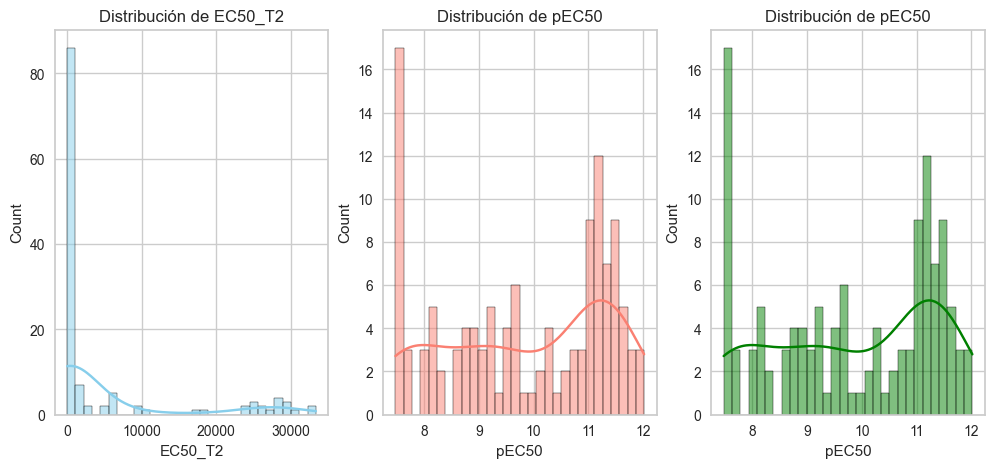

In [19]:
## Grafico de la distribucion de ec50 y pEC50
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(1, 3,  figsize=(12, 5))
sns.histplot(df_conocidos['EC50_T2'], bins=30, kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribución de EC50_T2')
sns.histplot(df_conocidos['pEC50'], bins=30, kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribución de pEC50') 
sns.histplot(df_Entropia['pEC50'], bins=30, kde=True, ax=ax[2], color='green')
ax[2].set_title('Distribución de pEC50') 
## Grafico de la distrubucion de ec50 y pEC50 --- IGNORE ---



## Pipelines de entrenamiento

In [20]:
# Parámetros globales para PyCaret
ignore_features = ['ID', 'EC50_T2', 'EC50_LOG_T2']
target = 'pEC50'

# Setup sin PCA
exp_no_pca = setup(
    data=df_conocidos, 
    target='pEC50',                 # columna objetivo
    ignore_features=ignore_features,
    normalize=True,   
    normalize_method='maxabs', 
    session_id=132400,              # como random_state
    verbose=False,
    experiment_name='GLP1_NO_PCA',
    fold=10,
    #use_gpu = True
)

# Setup con PCA
exp_pca = setup(
    data=df_conocidos, 
    target='pEC50',                 # columna objetivo
    ignore_features=ignore_features,
    normalize=True,    
    normalize_method='maxabs',     
    session_id=132400,              # como random_state
    verbose=False,
    experiment_name='GLP1_PCA',
    pca=True,
    pca_components=0.99, # o pca_components=0.95 para varianza explicada
    fold=10,
    #use_gpu = True
)

# Setup con Filtro por Entropía (Shannon, 10 bins) 
exp_entr = setup(
    data=df_Entropia, 
    target='pEC50',                 # columna objetivo
    ignore_features=ignore_features,
    normalize=True,    
    normalize_method='maxabs',     
    session_id=132400,              # como random_state
    verbose=False,
    experiment_name='GLP1_PCA',
    fold=10,
    #use_gpu = True
)



## Entrenamiento y comparación de modelos

## Detalles modelos    

In [21]:
# Obtener los 3 mejores modelos sin PCA
print("Mejores modelos sin PCA:")
best_models_no_pca = exp_no_pca.compare_models(sort='R2', n_select=10)

Mejores modelos sin PCA:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.6397,0.8498,0.8420,0.6092,0.0808,0.0698,0.2220
lightgbm,Light Gradient Boosting Machine,0.7234,0.9682,0.9383,0.5501,0.0897,0.0785,0.1090
rf,Random Forest Regressor,0.7492,0.9911,0.9414,0.5412,0.0900,0.0814,0.2670
gbr,Gradient Boosting Regressor,0.7122,1.0285,0.9714,0.5219,0.0929,0.0768,0.2080
ada,AdaBoost Regressor,0.7002,1.0457,0.9453,0.5163,0.0903,0.0773,0.1320
huber,Huber Regressor,0.7291,1.0328,0.9256,0.5094,0.0891,0.0796,0.0850
ridge,Ridge Regression,0.7206,1.0318,0.9285,0.5033,0.0897,0.0784,0.0620
br,Bayesian Ridge,0.7786,1.0682,0.9583,0.4889,0.0923,0.0844,0.0680
par,Passive Aggressive Regressor,0.7767,1.0820,0.9564,0.4886,0.0917,0.0839,0.0680
lr,Linear Regression,0.7755,1.1956,1.0085,0.4270,0.0977,0.0841,0.4720


## Detalles modelos con PCA

In [22]:
# 10. Obtener los 3 mejores modelos con PCA
print("Mejores modelos con PCA:")
best_models_pca = exp_pca.compare_models(sort='R2', n_select=10)


Mejores modelos con PCA:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.7508,1.0742,0.9358,0.4900,0.0897,0.0818,0.0840
lr,Linear Regression,0.7518,1.0904,0.9380,0.4839,0.0898,0.0821,0.0800
lar,Least Angle Regression,0.7518,1.0904,0.9380,0.4839,0.0898,0.0821,0.0730
br,Bayesian Ridge,0.7920,1.0965,0.9668,0.4776,0.0927,0.0857,0.0750
huber,Huber Regressor,0.7546,1.1155,0.9454,0.4727,0.0906,0.0824,0.0840
par,Passive Aggressive Regressor,0.7800,1.1118,0.9617,0.4663,0.0926,0.0850,0.0760
knn,K Neighbors Regressor,0.8243,1.2868,1.0707,0.4131,0.1009,0.0885,0.0790
et,Extra Trees Regressor,0.8194,1.2745,1.0581,0.4118,0.1005,0.0874,0.1470
omp,Orthogonal Matching Pursuit,0.8993,1.3173,1.0913,0.3749,0.1046,0.0965,0.0750
ada,AdaBoost Regressor,0.8844,1.3755,1.1172,0.3360,0.1059,0.0929,0.0950


In [23]:
# 10. Obtener los 3 mejores modelos con Entropia
print("Mejores modelos con Entropia:")
best_models_entropy = exp_entr.compare_models(sort='R2', n_select=10)

Mejores modelos con Entropia:


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.7054,0.9536,0.9072,0.5673,0.0865,0.0761,0.0800
ada,AdaBoost Regressor,0.7545,1.1195,0.9824,0.4773,0.0931,0.0819,0.0430
lightgbm,Light Gradient Boosting Machine,0.7432,1.1626,1.0066,0.4585,0.0943,0.0793,0.0470
gbr,Gradient Boosting Regressor,0.7541,1.1480,0.9885,0.4532,0.0938,0.0815,0.0740
rf,Random Forest Regressor,0.8279,1.1616,1.0264,0.4493,0.0977,0.0891,0.1100
ridge,Ridge Regression,0.8724,1.2799,1.0821,0.3969,0.1035,0.0944,0.0150
br,Bayesian Ridge,0.8896,1.3207,1.0970,0.3844,0.1047,0.0960,0.0180
knn,K Neighbors Regressor,0.9142,1.4989,1.1542,0.2674,0.1092,0.0977,0.0180
huber,Huber Regressor,1.0167,1.6666,1.2298,0.2062,0.1205,0.1104,0.0220
par,Passive Aggressive Regressor,1.0982,2.0859,1.3141,0.0739,0.1248,0.1235,0.0200


## Ajuste de modelos

In [32]:
# Afinar los mejores modelos sin PCA y guardarlos individualmente
from ray.tune.search.hyperopt import HyperOptSearch

print("----- Ajuste de modelos sin PCA -----")
tuned_no_pca = []
for i, mdl in enumerate( (best_models_no_pca[:3]), 1):
    print("----------")
    print(f"Ajustando modelo {mdl}")
    tuned = exp_no_pca.tune_model(mdl, n_iter=10, verbose=True, fold=10, search_library = 'scikit-optimize', search_algorithm = 'bayesian', early_stopping = True )
    tuned_no_pca.append(tuned)
    save_info = save_model(tuned, ruta_dir_modelos_no_pca / f"modelo_{i}_tuned_no_pca")
    if save_info is not None:
        print(f"Modelo guardado en: {save_info[1]}")
    else:
        print("No se pudo guardar el modelo.")


----- Ajuste de modelos sin PCA -----
----------
Ajustando modelo ExtraTreesRegressor(n_jobs=-1, random_state=132400)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9767,1.7004,1.3040,0.3265,0.1267,0.1104
1,0.7988,1.1185,1.0576,0.6378,0.0942,0.0763
2,0.2587,0.1296,0.3601,0.9063,0.0348,0.0284
3,0.6266,0.7573,0.8702,0.7209,0.0883,0.0739
4,1.3377,2.8335,1.6833,-0.2085,0.1639,0.1563
5,0.3922,0.2156,0.4643,0.8726,0.0430,0.0397
6,0.6222,0.9016,0.9495,0.4131,0.0869,0.0600
7,0.3332,0.2135,0.4621,0.8948,0.0491,0.0395
8,0.7110,0.8693,0.9324,0.4041,0.0858,0.0711


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved
Modelo guardado en: ..\models\pycaret\modelos_GLP1_no_pca\modelo_1_tuned_no_pca.pkl
----------
Ajustando modelo LGBMRegressor(n_jobs=-1, random_state=132400)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9760,1.7674,1.3294,0.3000,0.1286,0.1105
1,0.7268,1.0168,1.0083,0.6708,0.0874,0.0663
2,0.6237,0.7364,0.8582,0.4675,0.0812,0.0655
3,0.5836,0.5787,0.7607,0.7867,0.0785,0.0689
4,1.1272,2.7870,1.6694,-0.1887,0.1630,0.1371
5,0.6125,0.6120,0.7823,0.6384,0.0764,0.0634
6,0.6596,0.5683,0.7538,0.6301,0.0672,0.0628
7,0.4639,0.3222,0.5676,0.8413,0.0552,0.0509
8,0.6677,0.5180,0.7197,0.6449,0.0659,0.0666


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Transformation Pipeline and Model Successfully Saved
Modelo guardado en: ..\models\pycaret\modelos_GLP1_no_pca\modelo_2_tuned_no_pca.pkl
----------
Ajustando modelo RandomForestRegressor(n_jobs=-1, random_state=132400)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9610,1.5153,1.2310,0.3998,0.1196,0.1072
1,0.8513,1.1695,1.0814,0.6213,0.0963,0.0818
2,0.4848,0.4093,0.6397,0.7041,0.0598,0.0516
3,0.6810,0.7673,0.8760,0.7172,0.0910,0.0816
4,1.3184,2.9346,1.7131,-0.2516,0.1663,0.1558
5,0.6257,0.4991,0.7064,0.7051,0.0653,0.0624
6,0.7596,0.7762,0.8810,0.4948,0.0804,0.0743
7,0.5163,0.3282,0.5729,0.8384,0.0588,0.0598
8,0.7993,0.7709,0.8780,0.4716,0.0793,0.0786


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved
Modelo guardado en: ..\models\pycaret\modelos_GLP1_no_pca\modelo_3_tuned_no_pca.pkl


In [33]:

# ensemble models
bagged_top5 = [ensemble_model(i) for i in tuned_no_pca]

# blend models
blender = blend_models(estimator_list = tuned_no_pca) 

# stack models
stacker = stack_models(estimator_list = tuned_no_pca) 


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0095,1.7918,1.3386,0.2903,0.1288,0.1114
1,0.9440,1.3422,1.1585,0.5654,0.1053,0.0928
2,0.5998,0.4621,0.6798,0.6659,0.0647,0.0642
3,0.7046,0.7689,0.8769,0.7166,0.0896,0.0819
4,1.3861,2.8250,1.6808,-0.2049,0.1629,0.1597
5,0.5759,0.4322,0.6574,0.7446,0.0598,0.0567
6,0.7262,0.8295,0.9108,0.4601,0.0810,0.0680
7,0.5007,0.3110,0.5577,0.8469,0.0584,0.0589
8,0.8188,0.9358,0.9674,0.3585,0.0891,0.0815


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0569,1.8413,1.3569,0.2707,0.1300,0.1164
1,0.8672,1.1192,1.0579,0.6376,0.0939,0.0834
2,0.6311,0.5367,0.7326,0.6120,0.0700,0.0678
3,0.7574,0.7514,0.8669,0.7230,0.0873,0.0861
4,1.3320,3.0856,1.7566,-0.3161,0.1701,0.1573
5,0.6117,0.5239,0.7238,0.6904,0.0657,0.0602
6,0.7381,0.8328,0.9126,0.4579,0.0816,0.0695
7,0.4682,0.2736,0.5231,0.8652,0.0519,0.0532
8,0.7959,0.8728,0.9342,0.4017,0.0850,0.0782


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.1266,1.8334,1.3540,0.2738,0.1310,0.1251
1,1.0303,1.4798,1.2165,0.5209,0.1113,0.1026
2,0.7268,0.6635,0.8146,0.5202,0.0777,0.0781
3,0.7899,0.8935,0.9453,0.6706,0.0959,0.0909
4,1.4174,3.0277,1.7400,-0.2913,0.1684,0.1648
5,0.6538,0.5892,0.7676,0.6518,0.0692,0.0635
6,0.8508,0.9601,0.9798,0.3751,0.0877,0.0808
7,0.6300,0.4673,0.6836,0.7699,0.0720,0.0754
8,0.9021,1.0657,1.0323,0.2695,0.0944,0.0890


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9641,1.6234,1.2741,0.3570,0.1236,0.1078
1,0.8642,1.2463,1.1164,0.5965,0.0989,0.0818
2,0.7456,0.7514,0.8669,0.4567,0.0827,0.0793
3,0.6264,0.6104,0.7813,0.7750,0.0802,0.0730
4,1.3212,3.1753,1.7819,-0.3543,0.1725,0.1577
5,0.5839,0.4317,0.6570,0.7449,0.0597,0.0573
6,0.5886,0.5798,0.7614,0.6226,0.0683,0.0561
7,0.3630,0.1833,0.4281,0.9097,0.0429,0.0411
8,0.7832,0.8424,0.9178,0.4225,0.0847,0.0787


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8691,1.5735,1.2544,0.3768,0.1212,0.0965
1,0.8447,1.2607,1.1228,0.5918,0.0984,0.0777
2,0.6903,0.6742,0.8211,0.5125,0.0778,0.0720
3,0.5894,0.5245,0.7243,0.8067,0.0730,0.0672
4,1.3434,3.4566,1.8592,-0.4743,0.1792,0.1615
5,0.6403,0.5245,0.7242,0.6901,0.0675,0.0640
6,0.4535,0.3288,0.5734,0.7860,0.0515,0.0439
7,0.3002,0.1487,0.3857,0.9268,0.0351,0.0315
8,0.7070,0.7179,0.8473,0.5079,0.0790,0.0717


In [35]:

# automl 
best = automl(optimize = 'R2')
print(best)

ExtraTreesRegressor(n_jobs=-1, random_state=132400)


In [36]:
results = pull()
display(results)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8691,1.5735,1.2544,0.3768,0.1212,0.0965
1,0.8447,1.2607,1.1228,0.5918,0.0984,0.0777
2,0.6903,0.6742,0.8211,0.5125,0.0778,0.0720
3,0.5894,0.5245,0.7243,0.8067,0.0730,0.0672
4,1.3434,3.4566,1.8592,-0.4743,0.1792,0.1615
5,0.6403,0.5245,0.7242,0.6901,0.0675,0.0640
6,0.4535,0.3288,0.5734,0.7860,0.0515,0.0439
7,0.3002,0.1487,0.3857,0.9268,0.0351,0.0315
8,0.7070,0.7179,0.8473,0.5079,0.0790,0.0717


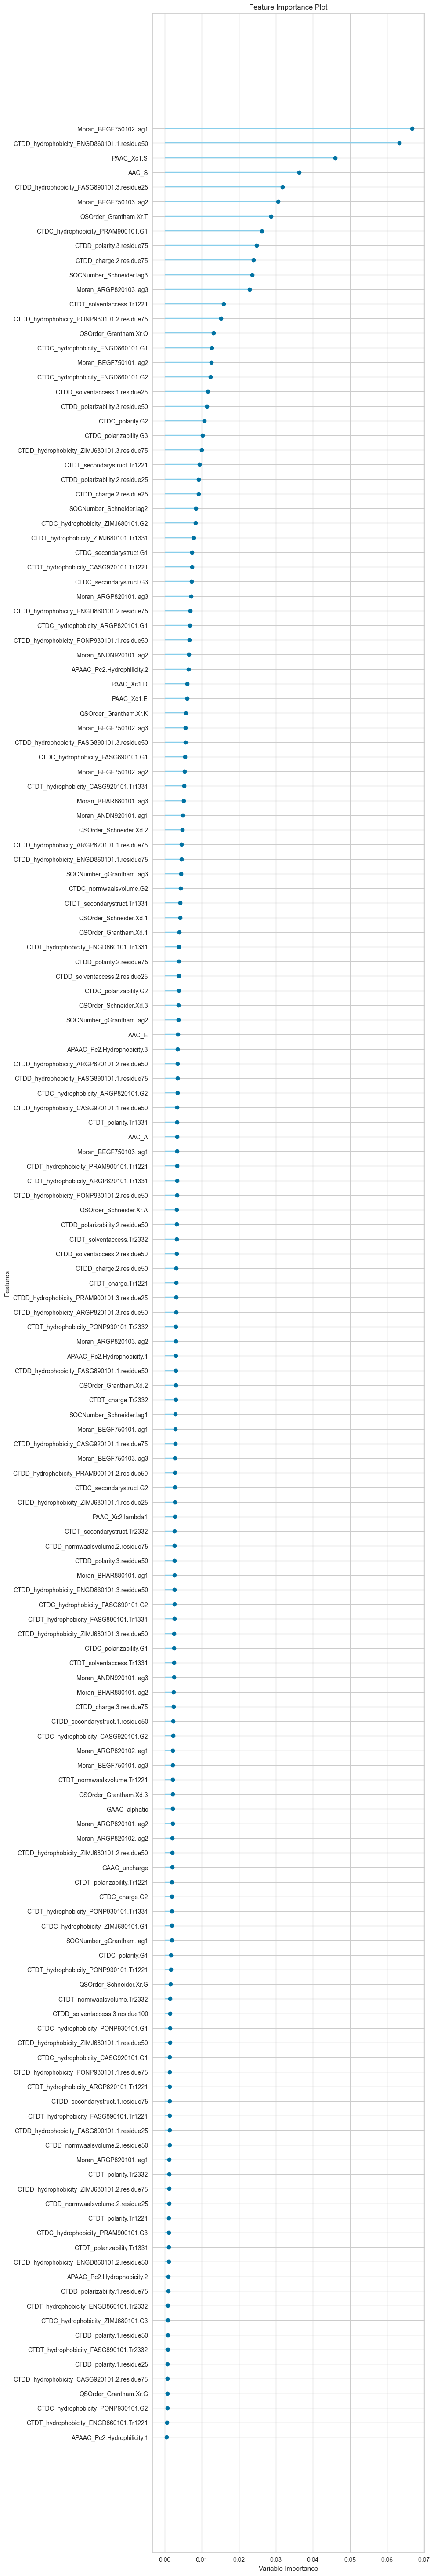

In [46]:



plot_model(best, plot = 'feature_all')

In [ ]:
# Crear y guardar el modelo apilado (stacking) sin PCA
stack_no_pca = exp_no_pca.stack_models(best_models_no_pca, verbose=False)
save_info = save_model(stack_no_pca, ruta_modelo_stack_no_pca)    

if save_info is not None:
        print(f"Modelo guardado en: {save_info[1]}")
else:
        print("No se pudo guardar el modelo.")


        print("No se pudo guardar el modelo.")

In [ ]:
best_all_no_pca = exp_no_pca.compare_models(sort='R2', include=best_models_no_pca + tuned_no_pca, )

In [ ]:

print("----- Ajuste de modelos con PCA -----")
# Afinar los mejores modelos con PCA y guardarlos individualmente
tuned_pca = []
for i, mdl in enumerate(best_models_pca[:4], 1):
    print("----------")
    print(f"Ajustando modelo {mdl}")    
    tuned = exp_pca.tune_model(mdl, n_iter=50 , verbose=False)
    tuned_pca.append(tuned)
    save_info = save_model(tuned, ruta_dir_modelos_pca / f"modelo_{i}_tuned_pca")
    if save_info is not None:
        print(f"Modelo guardado en: {save_info[1]}")
    else:
        print("No se pudo guardar el modelo.")



In [ ]:
best_all_pca = exp_pca.compare_models(sort='R2', include=best_models_pca + tuned_pca, )

## Apilado de modelos para genera una regresion logistica con el Voto de los mejores modelos
Esto permite una mejor generalización pues se usan los resultados de todos los modelos

In [ ]:
# Crear y guardar el modelo apilado (stacking) con PCA
stack_pca = exp_pca.stack_models(tuned_pca)
save_info = save_model(stack_pca, ruta_modelo_stack_pca)

if save_info is not None:
        print(f"Modelo guardado en: {save_info[1]}")
else:
        print("No se pudo guardar el modelo.")


        print("No se pudo guardar el modelo.")

## Analisis de los resultados de los modelos

In [ ]:
## Generar los graficos de los modelos y mostrar resultados
# es necesario cargar los graficos desde los archivos pues PyCaret no permite generarlos directamente como objetos

import math
import matplotlib.pyplot as plt

def comparar_modelos_por_plot(modelos, plot_type, carpeta_salida="plots_comparativos"):
    """
    Genera una figura combinada (rejilla) para comparar varios modelos PyCaret
    por un tipo de gráfico (error, residuals, feature, learning, etc.).
    """
    os.makedirs(carpeta_salida, exist_ok=True)
    rutas = []

    # Generar cada plot y guardarlo con nombre único
    for i, mdl in enumerate(modelos):
        nombre = mdl.__str__().split("(")[0].strip()
        nombre_sanitizado = nombre.replace(" ", "_").replace(":", "")
        ruta_destino = os.path.join(carpeta_salida, f"{plot_type}_{nombre_sanitizado}.png")

        # Generar el plot y obtener su ruta
        ruta_generada = plot_model(mdl, plot=plot_type, save=True, verbose=False)

        # Si el archivo generado existe, lo movemos/renombramos
        if os.path.exists(ruta_generada):
            os.replace(ruta_generada, ruta_destino)
        else:
            print(f"⚠️ No se encontró el archivo generado: {ruta_generada}")
            continue

        rutas.append((nombre, ruta_destino))
        print(f"✅ Guardado: {ruta_destino}")

    # Crear figura combinada
    cols = 5
    filas = math.ceil(len(rutas) / cols)
    fig, axes = plt.subplots(filas, cols, figsize=(cols * 4, filas * 4))
    axes = axes.flatten()

    for ax, (nombre, ruta) in zip(axes, rutas):
        img = plt.imread(ruta)
        ax.imshow(img)
        ax.set_title(nombre, fontsize=10)
        ax.axis("off")

    for ax in axes[len(rutas):]:
        ax.axis("off")

    plt.suptitle(f"Comparación de modelos - {plot_type}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# Guardar modelos y pipeline sin PCA
save_info = save_model(best_models_no_pca, ruta_pipeline_sin_pca)
if save_info is not None:
    print(f"Modelo guardado en: {save_info[1]}")
else:
    print("No se pudo guardar el modelo.")

# Guardar modelos y pipeline con PCA
save_info_pca = save_model(best_models_pca, ruta_pipeline_con_pca)
if save_info_pca is not None:
    print(f"Modelo guardado en: {save_info_pca[1]}")
else:
    print("No se pudo guardar el modelo.")

In [ ]:
df_conocidos

In [ ]:
exp_no_pca.plot_model(tuned_no_pca[0])
exp_no_pca.plot_model(tuned_no_pca[1])
exp_no_pca.plot_model(tuned_no_pca[2])
exp_no_pca.plot_model(stack_no_pca)


In [ ]:
exp_no_pca.plot_model(tuned_no_pca[0],"error")
exp_no_pca.plot_model(tuned_no_pca[1],"error")
exp_no_pca.plot_model(tuned_no_pca[2],"error")
exp_no_pca.plot_model(stack_no_pca,"error")


In [ ]:
exp_no_pca.plot_model(tuned_no_pca[0],"learning")
exp_no_pca.plot_model(tuned_no_pca[1],"learning")
exp_no_pca.plot_model(tuned_no_pca[2],"learning")
exp_no_pca.plot_model(stack_no_pca,"learning")

# PCA

In [ ]:
exp_pca.plot_model(tuned_pca[0])
exp_pca.plot_model(tuned_pca[1])
exp_pca.plot_model(tuned_pca[2])
exp_pca.plot_model(stack_pca)


----

In [ ]:
best_no_pca = compare_models(sort='R2', n_select=1)
tuned_no_pca = tune_model(best_no_pca, n_iter=50, optimize='R2')

In [ ]:
# Modelo predictivo con AutoML de PyCaret

# Configurar PyCaret
# Inicializar el pipeline: divide los datos, infiere tipos, y prepara los conjuntos para el modelado
s = setup(
    data=df_conocidos, 
    target='pEC50',                 # columna objetivo
    normalize=True,         # StandardScaler interno
    session_id=132400,              # como random_state
    ignore_features=["ID","EC50_LOG_T2","EC50_T2"], # Ignorar columnas que no son características
    verbose=True,                   # Poner en True para ver todos los detalles
    experiment_name="GLP-1 Regresion"
)



In [ ]:
# Comparar todos los modelos
best_models = compare_models(sort='R2', n_select=3) # Ordenamos por el RMSE

In [ ]:
best_models

In [ ]:
# Guardar el pipeline y el modelo completo en un archivo
save_info =  save_model(best_models, ruta_modelo_final)

if save_info is not None:
    print(F"Modelo guardado {save_info[1]}")
else:
    print(F"Modelo guardado")
    

In [ ]:
# # Cargar el pipeline del modelo desde el archivo
# print(F"Cargando modelo: {ruta_modelo_final}")
# best_models = load_model(ruta_modelo_final)

# print("\nModelo cargado:")
# print(best_models)


## Descripción de las métricas

### Métricas Basadas en Error

Las siguientes métricas miden el error de un modelo; por lo tanto, **un valor más bajo siempre es mejor**. Generalmente, se expresan en la misma unidad que la variable objetivo (a excepción de MAPE).

---

#### MAE (Mean Absolute Error - Error Absoluto Medio)

El **MAE** calcula el promedio de las diferencias absolutas entre los valores reales ($y_i$) y los predichos ($\hat{y}_i$). Mide la magnitud promedio de los errores, sin considerar si son positivos o negativos. Es menos sensible a los valores atípicos (outliers) que el MSE.

* **Significado**: Un MAE de 5 indica que, en promedio, las predicciones del modelo se desvían 5 unidades del valor real.
* **Fórmula**:
    $MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

---

#### MSE (Mean Squared Error - Error Cuadrático Medio)

El **MSE** calcula el promedio de los errores al cuadrado. Al elevar el error al cuadrado, penaliza más fuertemente los errores grandes. Esto lo hace muy sensible a los outliers.

* **Significado**: Es más difícil de interpretar directamente, ya que las unidades están al cuadrado. Se usa principalmente como función de coste durante el entrenamiento del modelo.
* **Fórmula**:
    $MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

---

#### RMSE (Root Mean Squared Error - Raíz del Error Cuadrático Medio)

El **RMSE** es  la raíz cuadrada del MSE. Su principal ventaja es que devuelve el error a las unidades originales de la variable objetivo, lo que lo hace mucho más fácil de interpretar que el MSE. Al igual que el MSE, penaliza más los errores grandes.

* **Significado**: Un RMSE de 7.5 significa que, en promedio, el modelo se equivoca en 7.5 unidades. Es una de las métricas más populares para evaluar modelos de regresión.
* **Fórmula**:
    $RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

---

#### RMSLE (Root Mean Squared Logarithmic Error - Raíz del Error Logarítmico Cuadrático Medio)

El **RMSLE** calcula el RMSE sobre el logaritmo de los valores predichos y reales. Es útil cuando no se desea penalizar tanto la diferencia entre valores grandes, sino más bien la relación porcentual. Solo se puede usar si los valores son positivos.

* **Significado**: Mide el error relativo. Por ejemplo, un error de predecir 110 cuando el valor real es 100 se considerará similar a un error de predecir 1100 cuando el valor es 1000. Es robusto frente a outliers.
* **Fórmula**:
    $RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\log(1 + \hat{y}_i) - \log(1 + y_i))^2}$

---

#### MAPE (Mean Absolute Percentage Error - Error Porcentual Absoluto Medio)

El **MAPE** expresa el error como un porcentaje promedio del valor real. Esto lo hace muy intuitivo y fácil de comunicar a audiencias no técnicas. Sin embargo, tiene un gran inconveniente: no se puede usar si los valores reales ($y_i$) son cero.

* **Significado**: Un MAPE del 15% significa que, en promedio, el error de predicción es del 15% del valor real.
* **Fórmula**:
    $MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$

---

### Métrica de Rendimiento

A diferencia de las anteriores, para esta métrica **un valor más alto es mejor**.

#### R² (Coeficiente de Determinación)

**R²**, o R-cuadrado, mide la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. En otras palabras, indica qué tan bien se ajusta el modelo a los datos.

* **Significado**: Su valor va de 0 a 1. Un **R² de 0.85** significa que el modelo es capaz de explicar el **85% de la variabilidad** de los datos. Un valor cercano a 1 indica un buen ajuste, mientras que un valor cercano a 0 indica que el modelo no es mejor que simplemente predecir el promedio de los datos.
* **Fórmula**:
    $R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$
    donde $\bar{y}$ es la media de los valores reales.

---



## Plot de Estadisticas del mejor modelo

In [ ]:
mdl1 = best_models[0]
mdl2 = best_models[1]
mdl3 = best_models[2]

In [ ]:
plot_model(mdl1, plot = 'residuals')

In [ ]:
plot_model(mdl1, plot = 'error')

In [ ]:
# plot feature importance
plot_model(mdl1, plot = 'feature')

In [ ]:
plot_model(mdl1, plot = 'learning')

In [ ]:
# Validation Curve
plot_model(mdl1, plot = 'vc')

## Ajuste de los tres mejores modelos

In [ ]:
# from pycaret.regression import load_model, predict_model
# import pandas as pd

# #  Cargar el pipeline del modelo desde el archivo
# print("Cargando modelo...")
# modelo_cargado = load_model(mode)

# print("\nModelo cargado:")
# print(modelo_cargado)

In [ ]:
# Ajuste de los mejores modelos 

# Realizar una búsqueda más exhaustiva con 50 iteraciones en lugar de 10
tuned_model1 = tune_model(mdl1, n_iter=50)
tuned_model2 = tune_model(mdl2, n_iter=50)
tuned_model3 = tune_model(mdl3, n_iter=50)

In [ ]:
tuned_model1

In [ ]:
# Crear un stack de nodelos para mejorar las predicciones

stack_con_modelos_ajustados = stack_models(estimator_list=[tuned_model1, tuned_model2, tuned_model3])

In [ ]:
stack_con_modelos_ajustados

In [ ]:
# Guardado del Stack y el nuevo modelo completo en un archivo

save_info = save_model(stack_con_modelos_ajustados, ruta_modelo_stack_final)

if save_info is not None:
    print(F"Modelo guardado {save_info[1]}")
else:
    print(F"Modelo guardado")
    

In [ ]:
# Cargar el pipeline del modelo desde el archivo
print(F"Cargando modelo: {ruta_modelo_stack_final}")
stack_con_modelo_ajustados = load_model(ruta_modelo_stack_final)

print("\nModelo cargado:")
print(stack_con_modelo_ajustados)


In [ ]:
plot_model(stack_con_modelos_ajustados, plot = 'error')
plot_model(mdl1, plot = 'error')

In [ ]:
df_desconocidos

In [ ]:
#  Realizar predicciones con el modelo cargado
# El pipeline se encarga de todo el preprocesamiento y el ensembling automáticamente

print("\nRealizando predicciones con el modelo Stacking...")
predicciones_stacking = predict_model(stack_con_modelos_ajustados, data=df_desconocidos)

In [ ]:
# Convertir los resultados de pEC50 a EC50
predicciones_stacking['EC50_Predicho_uM'] = (10**(-predicciones_stacking['prediction_label'])) * 1e12


In [ ]:
predicciones_stacking

In [ ]:
df_conocidos

In [ ]:
#  Realizar predicciones con el modelo cargado
# El pipeline se encarga de todo el preprocesamiento y el ensembling automáticamente


print("\nRealizando predicciones con el modelo Stacking...")
predicciones_conocidos = predict_model(stack_con_modelos_ajustados, data=df_conocidos)

# Convertir los resultados de pEC50 a EC50
predicciones_conocidos['EC50_Predicho_uM'] = (10**(-predicciones_conocidos['prediction_label'])) * 1e12

In [ ]:
predicciones_conocidos